In [1]:
from games_setup import *
from SBMLLint.common import constants as cn
from SBMLLint.common.molecule import Molecule, MoleculeStoichiometry
from SBMLLint.common.reaction import Reaction
from SBMLLint.games.som import SOM
from SBMLLint.common.simple_sbml import SimpleSBML

import collections
import itertools
import networkx as nx
import numpy as np
import pandas as pd
#
from SBMLLint.common.stoichiometry_matrix import StoichiometryMatrix
from SBMLLint.games.mesgraph import MESGraph
from SBMLLint.games.games_pp import GAMES_PP, SOMStoichiometry, SOMReaction, TOLERANCE
from SBMLLint.games.games_report import GAMESReport, SimplifiedReaction

ReactionOperation = collections.namedtuple("ReactionOperation", 
    "reaction operation")

Current Directory: /Users/woosubshin/Desktop/ModelEngineering/SBMLLint/notebook


In [2]:
# Model 248 is for canceling error
# Model 14/167 for a type three error / echelon
# Model 7 for type 1 error
# Model 18 for type 2 error

######## examine model 628 for large echelon error ###########
simple = load_file_from_curated_data(167)
# for r in simple.reactions:
#   if r.category != cn.REACTION_BOUNDARY and r.category != cn.REACTION_1_1:
#     print(r.makeIdentifier(is_include_kinetics=False))
m = GAMES_PP(simple)
m.analyze()
gr = GAMESReport(m)

We just analyzed the data...
Type I error:  []
Type II error:  []
Canceling error:  []
Echelon error:  [statPhosphorylation:  -> {species_test}]
Type III error:  [PstatDimerisation: 2.00 {Pstat_sol} -> 2.00 {Pstat_nuc=stat_nuc=stat_sol}]
Type I-SOM error:  set()


In [3]:
np.linalg.cond(m.lower_inverse)

1.6403882032022075

In [4]:
len(simple.reactions)

7

In [5]:
type1_report, error_num = gr.reportTypeOneError(m.type_one_errors, explain_details=True)
print(type1_report)
print(error_num)


[]


In [6]:
type2_report, error_num = gr.reportTypeTwoError(m.type_two_errors, explain_details=True)
print(type2_report)
print(error_num)


[]


In [7]:
canceling_report, error_num = gr.reportCancelingError(m.canceling_errors, explain_details=True)
print(canceling_report)
print(error_num)


[]


In [8]:
m.echelon_errors[0]

statPhosphorylation:  -> {species_test}

In [9]:
len(simple.reactions)

7

In [10]:
echelon_report, error_num = gr.reportEchelonError(m.echelon_errors, explain_details=True)
print(echelon_report)
print(error_num)


We detected a mass imbalance
:  -> species_test

from the following reactions.

1. PstatDimerisation: 2.00 Pstat_sol -> PstatDimer_sol
2. statPhosphorylation: stat_sol -> Pstat_sol + species_test
3. PstatDimerisationNuc: 2.00 Pstat_nuc -> PstatDimer_nuc

----------------------------------------------------------------------

These uni-uni reactions created mass-equivalence.
(The molecules within a curly bracket are inferred to have the same atomic mass.)

4. PstatDimer__import: PstatDimer_sol -> PstatDimer_nuc;   {PstatDimer_sol=PstatDimer_nuc}

5. stat_export: stat_sol -> stat_nuc;   {stat_sol=stat_nuc}

6. statDephosphorylation: Pstat_nuc -> stat_nuc;   {stat_sol=stat_nuc=Pstat_nuc}


----------------------------------------------------------------------

Based on the reactions above, we have mass-equivalent pseudo reactions.
(pseudo 1.) PstatDimerisation: 2.00 {Pstat_sol} -> {PstatDimer_nuc=PstatDimer_sol}
(pseudo 2.) statPhosphorylation: {Pstat_nuc=stat_nuc=stat_sol} -> {species_t

In [10]:
m.nodes

NodeView(({ce4p}, {cglcex}, {ferdicoa}, {csed7p}, {cf6p=cfdp=cg1p=cg6p=cpg=crib5p=cribu5p=cxyl5p}, {accoa=cdhap=cgap=cpep=cpg2=cpg3=cpgp=cpyr=malcoa}, {fer=fer_ext=fercoa}, {cur=cur_ext}))

In [11]:
som = m.getNode(simple.getMolecule("cf6p"))
print(som.identifier)

{cf6p=cfdp=cg1p=cg6p=cpg=crib5p=cribu5p=cxyl5p}


In [15]:
list(m.nodes)[4]

{cf6p=cfdp=cg1p=cg6p=cpg=crib5p=cribu5p=cxyl5p}

In [18]:
report, count = gr.reportReactionsInSOM(list(m.nodes)[4])
print(report)


1. vPGDH: cpg -> cribu5p;   {cpg=cribu5p}

2. vRu5P: cribu5p -> cxyl5p;   {cpg=cribu5p=cxyl5p}

3. vG6PDH: cg6p -> cpg;   {cpg=cribu5p=cxyl5p=cg6p}

4. vR5PI: cribu5p -> crib5p;   {cpg=cribu5p=cxyl5p=cg6p=crib5p}

5. vPGI: cg6p -> cf6p;   {cpg=cribu5p=cxyl5p=cg6p=crib5p=cf6p}

6. vPGM: cg6p -> cg1p;   {cpg=cribu5p=cxyl5p=cg6p=crib5p=cf6p=cg1p}

7. vPFK: cf6p -> cfdp;   {cpg=cribu5p=cxyl5p=cg6p=crib5p=cf6p=cg1p=cfdp}



In [69]:
def reportReactionsInSOM(som, reaction_count=0):
  """
  Generate report on reactions created a SOM,
  in order to demonstrate how the SOM was constructed.
  :param som SOM:
  :param int reaction_count:
  :return str: report
  :return int: reaction_count
  """
  report = cn.NULL_STR
  reaction_count += 1
  molecules = []
  reactions = list(som.reactions)
  molecules.append(reactions[0].reactants[0].molecule.name)
  molecules.append(reactions[0].products[0].molecule.name)
  report = report + "\n%d. %s;   %s\n" % (reaction_count,
                                          reactions[0].makeIdentifier(is_include_kinetics=False),
                                          '{' + '='.join(molecules) + '}') 
  res = reactions[1:]
  flag = 0
  while res:
    flag += 1
    if flag > 50:
      break
    reaction = res[0]
    reactant = reaction.reactants[0].molecule.name
    product = reaction.products[0].molecule.name
    if (reactant not in molecules) and (product not in molecules):
      res.remove(reaction)
      res.append(reaction)
    else:
      if reactant not in molecules and product in molecules:
        molecules.append(reactant)
      if reactant in molecules and product not in molecules:
        molecules.append(product)
      if reactant in molecules and product in molecules:
        pass
      reaction_count += 1
      report = report + "\n%d. %s;   %s\n" % (reaction_count,
                                              reaction.makeIdentifier(is_include_kinetics=False),
                                              '{' + '='.join(molecules) + '}') 
      res.remove(reaction)
  return report, reaction_count

In [70]:
som

{cf6p=cfdp=cg1p=cg6p=cpg=crib5p=cribu5p=cxyl5p}

In [72]:
report, count = reportReactionsInSOM(som, 10)
print(report)
type(report)


11. vPGM: cg6p -> cg1p;   {cg6p=cg1p}

12. vG6PDH: cg6p -> cpg;   {cg6p=cg1p=cpg}

13. vPGI: cg6p -> cf6p;   {cg6p=cg1p=cpg=cf6p}

14. vPFK: cf6p -> cfdp;   {cg6p=cg1p=cpg=cf6p=cfdp}

15. vPGDH: cpg -> cribu5p;   {cg6p=cg1p=cpg=cf6p=cfdp=cribu5p}

16. vR5PI: cribu5p -> crib5p;   {cg6p=cg1p=cpg=cf6p=cfdp=cribu5p=crib5p}

17. vRu5P: cribu5p -> cxyl5p;   {cg6p=cg1p=cpg=cf6p=cfdp=cribu5p=crib5p=cxyl5p}



str

In [45]:
a = {'s', 'b', 'd'}
'='.join(a)

's=b=d'

In [64]:

report = cn.NULL_STR
reaction_count = 0
reaction_count += 1
molecules = []
reactions = list(som.reactions)
molecules.append(reactions[0].reactants[0].molecule.name)
molecules.append(reactions[0].products[0].molecule.name)
report = report + "\n%d. %s;   %s\n" % (reaction_count,
                                        reactions[0].makeIdentifier(is_include_kinetics=False),
                                        '{' + '='.join(molecules) + '}') 
res = reactions[1:]
flag = 0
while res:
  flag += 1
  if flag > 50:
    break
  reaction = res[0]
  print("we're on reaction: ", reaction.label)
  reactant = reaction.reactants[0].molecule.name
  product = reaction.products[0].molecule.name
  if (reactant not in molecules) and (product not in molecules):
    print("we append the reactions %s in the back" % reaction.label)
    res.remove(reaction)
    res.append(reaction)
  else:
    if reactant not in molecules and product in molecules:
      molecules.append(reactant)
    if reactant in molecules and product not in molecules:
      molecules.append(product)
    if reactant in molecules and product in molecules:
      pass
    reaction_count += 1
    report = report + "\n%d. %s;   %s\n" % (reaction_count,
                                            reaction.makeIdentifier(is_include_kinetics=False),
                                            '{' + '='.join(molecules) + '}') 
    res.remove(reaction)

we're on reaction:  vRu5P
we append the reactions vRu5P in the back
we're on reaction:  vPFK
we append the reactions vPFK in the back
we're on reaction:  vPGDH
we append the reactions vPGDH in the back
we're on reaction:  vG6PDH
we're on reaction:  vPGI
we're on reaction:  vR5PI
we append the reactions vR5PI in the back
we're on reaction:  vRu5P
we append the reactions vRu5P in the back
we're on reaction:  vPFK
we're on reaction:  vPGDH
we're on reaction:  vR5PI
we're on reaction:  vRu5P


In [65]:
print(report)
print(flag)


1. vPGM: cg6p -> cg1p;   {cg6p=cg1p}

2. vG6PDH: cg6p -> cpg;   {cg6p=cg1p=cpg}

3. vPGI: cg6p -> cf6p;   {cg6p=cg1p=cpg=cf6p}

4. vPFK: cf6p -> cfdp;   {cg6p=cg1p=cpg=cf6p=cfdp}

5. vPGDH: cpg -> cribu5p;   {cg6p=cg1p=cpg=cf6p=cfdp=cribu5p}

6. vR5PI: cribu5p -> crib5p;   {cg6p=cg1p=cpg=cf6p=cfdp=cribu5p=crib5p}

7. vRu5P: cribu5p -> cxyl5p;   {cg6p=cg1p=cpg=cf6p=cfdp=cribu5p=crib5p=cxyl5p}

11


In [11]:
type3_report, error_num = gr.reportTypeThreeError(m.type_three_errors, explain_details=True)
print(type3_report)
print(error_num)

We detected a mass imbalance from the following reactions:

1. PstatDimerisation: 2.00 Pstat_sol -> PstatDimer_sol
2. PstatDimerisationNuc: 2.00 Pstat_nuc -> PstatDimer_nuc

----------------------------------------------------------------------

These uni-uni reactions created mass-equivalence.
(The molecules within a curly bracket are inferred to have the same atomic mass.)

3. PstatDimer__import: PstatDimer_sol -> PstatDimer_nuc;   {PstatDimer_sol=PstatDimer_nuc}

4. stat_export: stat_sol -> stat_nuc;   {stat_sol=stat_nuc}

5. statDephosphorylation: Pstat_nuc -> stat_nuc;   {stat_sol=stat_nuc=Pstat_nuc}


----------------------------------------------------------------------

These multi-uni (uni-multi) reactions created mass-inequality.

6. statPhosphorylation: stat_sol -> Pstat_sol + species_test

----------------------------------------------------------------------

Based on the reactions above, we have mass-equivalent pseudo reactions.

(pseudo 1.) PstatDimerisation: 2.00 {Pstat

In [11]:
m.rref_operation.dot(m.lower_inverse)

,vTA,DCS,vTKA,vPTS,vALDO,CURS,vTKB
vTA,3.0,0.0,2.0,0.0,-1.0,0.0,3.0
DCS,-0.5,0.5,-0.5,0.0,0.5,-0.5,-0.5
vTKA,-1.0,0.0,-1.0,0.0,1.0,0.0,-2.0
vPTS,2.0,0.0,2.0,1.0,-1.0,0.0,2.0
vALDO,2.0,0.0,2.0,0.0,-1.0,0.0,2.0
CURS,1.0,0.0,1.0,0.0,-1.0,0.0,1.0
vTKB,1.0,-1.0,1.0,0.0,-1.0,-1.0,1.0


In [30]:
# print(m.getNode(simple.getMolecule("CamR_Ca3_ABD_CaMKII")))
# reaction = m.echelon_errors[0]
# print(simple.getReaction("reaction_369"))
operation_df = gr.getOperationMatrix()
operation_df

reaction_label = m.echelon_errors[0].label
operation_series = operation_df.T[reaction_label]
result_series = gr.getResultingSeries(reaction_label)
#operation_df = self.getOperationMatrix()
reaction_operations = gr.convertOperationSeriesToReactionOperations(operation_series)
op_stoi_mat = gr.getOperationStoichiometryMatrix(reaction_operations)
print(len(op_stoi_mat.index) == len(set(op_stoi_mat.index)))
op_stoi_mat

reaction_index = [op.reaction for op in reaction_operations]
print(reaction_index)
operation_series = pd.Series([val.operation for val in reaction_operations], index=reaction_index)
print(operation_series)
resulting_reaction = op_stoi_mat.dot(operation_series)
print(resulting_reaction)

True
['reaction_50', 'reaction_63', 'reaction_369', 'reaction_179', 'reaction_7', 'reaction_28', 'reaction_185', 'reaction_45', 'reaction_29', 'reaction_184', 'reaction_383', 'reaction_181', 'reaction_48', 'reaction_189', 'reaction_61', 'reaction_51', 'reaction_190', 'reaction_227', 'reaction_228', 'reaction_391', 'reaction_243', 'reaction_86', 'reaction_244', 'reaction_117', 'reaction_250', 'reaction_285', 'reaction_282', 'reaction_266']
reaction_50    -3.000000e+00
reaction_63     1.000000e+00
reaction_369   -1.149855e+15
reaction_179   -9.582127e+14
reaction_7      1.149855e+15
reaction_28    -3.000000e+00
reaction_185    8.662614e-02
reaction_45     1.149855e+15
reaction_29     2.108068e+15
reaction_184    9.582127e+14
reaction_383    3.343465e-01
reaction_181   -1.149855e+15
reaction_48     2.108068e+15
reaction_189   -9.582127e+14
reaction_61     2.108068e+15
reaction_51     3.000000e+00
reaction_190    2.108068e+15
reaction_227   -2.299710e+15
reaction_228    1.149855e+15
reacti

In [55]:
reaction_index = [op.reaction for op in reaction_operations]
fake_series = pd.Series([val.operation for val in reaction_operations], index=reaction_index)
fake_series

reaction_369    1.000000e+00
reaction_175   -2.000000e+00
reaction_216   -6.004800e+15
reaction_124    6.004800e+15
reaction_176    1.000000e+00
reaction_210    6.004800e+15
reaction_27    -6.004800e+15
reaction_293    6.004800e+15
reaction_4      1.000000e+00
reaction_187    1.000000e+00
reaction_112    6.004800e+15
reaction_109   -6.004800e+15
reaction_314    6.004800e+15
reaction_292   -6.004800e+15
reaction_227   -1.000000e+00
reaction_60    -6.004800e+15
dtype: float64

In [37]:
print(m.convertReactionToSOMReaction(simple.getReaction("reaction_216")))
print(m.convertReactionToSOMReaction(simple.getReaction("reaction_124")))

reaction_216: {CamR_Ca2_BD_PP2B} -> {PP2B} + {CamR_Ca2_BD, CamT_Ca2_BD}
reaction_124: {CamR_Ca4_ABCD, CamT_Ca4_ABCD} -> {Ca} + {CamR_Ca3_ABD, CamT_Ca3_ABD}


In [35]:
operation_series[abs(operation_series) > 0]

reaction_369    1.000000e+00
reaction_175   -2.000000e+00
reaction_216   -6.004800e+15
reaction_124    6.004800e+15
reaction_176    1.000000e+00
reaction_210    6.004800e+15
reaction_27    -6.004800e+15
reaction_293    6.004800e+15
reaction_4      1.000000e+00
reaction_187    1.000000e+00
reaction_112    6.004800e+15
reaction_109   -6.004800e+15
reaction_314    6.004800e+15
reaction_292   -6.004800e+15
reaction_227   -1.000000e+00
reaction_60    -6.004800e+15
Name: reaction_369, dtype: float64

In [4]:
echelon_report, error_num = gr.reportEchelonError([m.echelon_errors[0]])
print(echelon_report)
detailed_echelon_report, error_num = gr.reportEchelonError([m.echelon_errors[0]], explain_details=True)
print(detailed_echelon_report)
print(error_num)


We detected a mass imbalance
: 0.50 crib5p -> 

from the following reactions.

1. vTA: cgap + csed7p -> cf6p + ce4p
2. vTKA: crib5p + cxyl5p -> cgap + csed7p
3. vALDO: cfdp -> cdhap + cgap
4. vTKB: ce4p + cxyl5p -> cgap + cf6p
5. vrpGluMu: cpg3 -> cpg2
6. vGAPDH: cgap -> cpgp
7. vENO: cpg2 -> cpep
8. vPK: cpep -> cpyr
9. vTIS: cdhap -> cgap
10. vPGK: cpgp -> cpg3

**********************************************************************



We detected a mass imbalance
: 0.50 crib5p -> 

from the following reactions.

1. vTA: cgap + csed7p -> cf6p + ce4p
2. vTKA: crib5p + cxyl5p -> cgap + csed7p
3. vALDO: cfdp -> cdhap + cgap
4. vTKB: ce4p + cxyl5p -> cgap + cf6p

----------------------------------------------------------------------

These uni-uni reactions created mass-equivalence.
5. vrpGluMu: cpg3 -> cpg2
6. vGAPDH: cgap -> cpgp
7. vENO: cpg2 -> cpep
8. vPK: cpep -> cpyr
9. vTIS: cdhap -> cgap
10. vPGK: cpgp -> cpg3

--------------------------------------------------------------------

In [23]:
type3_report, error_num = gr.reportTypeThreeError(m.type_three_errors)
print(type3_report)
detailed_type3_report, error_num = gr.reportTypeThreeError(m.type_three_errors, explain_details=True)
print(detailed_type3_report)
print(error_num)



[]


In [ ]:
"%.2f" % (3.00)

In [11]:
# this will test which model has which error;;
model_count = 0
count = 0
for i in range(1, 704):
  try:
    simple = load_file_from_curated_data(i)
    model_count += 1
    if model_count%100 == 0:
      print("we are doing model", model_count)
    m = GAMES_PP(simple)
    m.analyze(error_details=False)
    gr = GAMESReport(m)
    if m.echelon_errors:
      res, error_num = gr.reportEchelonError(m.echelon_errors, explain_details=True)
      if not res:
        count += 1
        print("model", model_count, " has a really wrong echelon error!")
        if count == 5:
          break
  except:
    pass

we are doing model 100
we are doing model 200
we are doing model 300
we are doing model 400
we are doing model 500
we are doing model 600
model 623  has a really wrong echelon error!


In [10]:
count = 0
model_count = 0
res, error_num = gr.reportEchelonError(m.echelon_errors, explain_details=True)
if not res:
  count += 1
  print("model", model_count, " has a really wrong echelon error!")


model 0  has a really wrong echelon error!


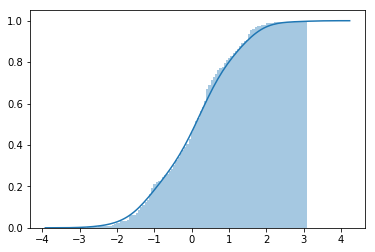

In [12]:


x = np.random.randn(200)
sns.distplot(x, hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True), bins = 100)
             